In [1]:
colors = {
    "p53": "#008DD5",
    "nutlin": "#DB5461",
    "nfkb": "#C33149",
    "tnf": "#107E7D",
    "gray": "#DAE0DC"
}

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from scipy.signal import find_peaks
from tqdm import tqdm
import pickle
import gzip

In [3]:
# defining parameters from Krishna/Jensen

k_Nin = 5.4 # min^{-1}
k_lin = 0.018 # min^{-1} 
k_t = 1.03 # mu * M^{-1} * min^{-1}
k_tl = 0.24 # min^{-1}
K_I = 0.035 # mu * M
K_N = 0.029 # mu * M
gamma_m = 0.017 # min^{-1}
alpha = 1.05 # mu * M^{-1} * min^{-1}
N_tot = 1.0 # mu * M
k_a = 0.24 # min^{-1}
k_i = 0.18 # min^{-1}
k_p = 0.036 # min^{-1}
k_A20 = 0.0018 # mu * M
IKK_tot = 2.0 # mu * M
A20 = 0.0026 # mu * M



In [4]:
omega = 1
no_osc = 400
Amp1 = 0.24
T_intt = 108.44444444444444
A_intt = 0.1293511878383227
T_extt = omega * T_intt

# NFkB scaling factor for the plots
x = 5

# Around 4664 minutes for 400 nfkb oscillations with current params
transient_window = 10000

In [5]:
# defining equations from Krishna/Jensen
def N_n_change(t, N_n, I_m, I, IKK_a, IKK_i, TNF):
    dN_ndt = k_Nin * (N_tot - N_n) * K_I / (K_I + I) - k_lin * I * (N_n / (K_N + N_n))
    return dN_ndt

def I_m_change(t, N_n, I_m, I, IKK_a, IKK_i, TNF):
    dI_mdt = k_t * (N_n**2) - gamma_m * I_m
    return dI_mdt

def I_change(t, N_n, I_m, I, IKK_a, IKK_i, TNF):
    dIdt = k_tl * I_m - alpha * IKK_a * (N_tot - N_n) * I / (K_I + I)
    return dIdt

def IKK_a_change(t, N_n, I_m, I, IKK_a, IKK_i, TNF):
    dIKK_adt = k_a * TNF * (IKK_tot - IKK_a - IKK_i) - k_i * IKK_a
    return dIKK_adt

def IKK_i_change(t, N_n, I_m, I, IKK_a, IKK_i, TNF):
    dIKK_idt = k_i * IKK_a - k_p * IKK_i * k_A20 / (k_A20 + A20 * TNF)
    return dIKK_idt

def system_nfkb(t, y, Amp_new):
    # Extract current state variables, assume TNF is not part of y here
    N_n, I_m, I, IKK_a, IKK_i = y
    # Dynamically compute TNF based on current time t (this means it will be a constant passed to the next equations for this dt)
    TNF = k + Amp_new * np.sin(np.pi * (1 / T_extt) * t*2*np.pi)
    # calling differential equation functions, passing TNF as an argument
    # Updating function definitions accordingly if they require TNF
    return [N_n_change(t, *y, TNF), 
            I_m_change(t, *y, TNF), 
            I_change(t, *y, TNF), 
            IKK_a_change(t, *y, TNF), 
            IKK_i_change(t, *y, TNF)]

In [6]:
# defining function to oscillate TNF (sinusoidal)
def TNF_sin_osc(oscillations, T_int, Amp, OOmega, N_n0, I_m0, I0, IKK_a0, IKK_i0):

    # calculating the period of TNF in order to simulate with the desired ratio of external over internal period
    T_ext = OOmega * T_int
    omega = T_int / T_ext

    history = {"t":[] ,"N_n": [], "I_m": [], "I": [], "IKK_a":[], "IKK_i":[], "TNF":[]}

    
    for i in tqdm(range(oscillations)):
        if i == 0:
            state = N_n0, I_m0, I0, IKK_a0, IKK_i0
        else:
            state = history["N_n"][-1], history["I_m"][-1], history["I"][-1], history["IKK_a"][-1], history["IKK_i"][-1]

        sys = solve_ivp(system_nfkb, (0, T_ext), state, args=(Amp,), method='LSODA', max_step=0.5, dense_output=True) # Is this step size too low?
        
        N_n, I_m, I, IKK_a, IKK_i = sys["y"][0], sys["y"][1], sys["y"][2], sys["y"][3], sys["y"][4]

        new_t = np.array(sys["t"]) + (history["t"][-1] if history["t"] else 0)
        history["t"].extend(new_t)
        history["N_n"].extend(N_n)
        history["I_m"].extend(I_m)
        history["I"].extend(I)
        history["IKK_a"].extend(IKK_a)
        history["IKK_i"].extend(IKK_i)
        history["TNF"].extend(0.5 + Amp * np.sin(np.pi * (1 / T_ext) * new_t))

    return history, T_ext

In [1]:
# NFkB, Im, I, IKK_A, IKK_i
p0 = [0.037770776771579556, 0.4050017925580332, 4.076546559955566, 0.1799999999999995, 1.5500000000000012]

p0_delta = p0.copy()
p0_delta[0] = p0_delta[0] + 1e-15

In [8]:
# simulating system with sinus oscillations
sim_0, T_ext_0 = TNF_sin_osc(no_osc, T_intt, Amp1, omega, *p0)

  0%|          | 0/400 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/Users/erik/Documents/Studie/Projekt/python/p53/env/lib/python3.11/site-packages/scipy/integrate/_ivp/base.py", line 154, in fun
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
    return self.fun_single(t, y)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/erik/Documents/Studie/Projekt/python/p53/env/lib/python3.11/site-packages/scipy/integrate/_ivp/base.py", line 23, in fun_wrapped
    return np.asarray(fun(t, y), dtype=dtype)
                      ^^^^^^^^^
  File "/Users/erik/Documents/Studie/Projekt/python/p53/env/lib/python3.11/site-packages/scipy/integrate/_ivp/ivp.py", line 588, in fun
    return fun(t, x, *args)
           ^^^^^^^^^^^^^^^^
  File "/var/folders/k7/f1crpym10dq1jlwf0j2n3h080000gn/T/ipykernel_66010/4154720660.py", line 26, i

: 

In [ ]:
# simulating system with sinus oscillations
sim_delta, T_ext_delta = TNF_sin_osc(no_osc, T_intt, Amp1, omega, *p0_delta)

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [00:01<00:00, 234.73it/s]


In [67]:
# unpacking
t0, N0, Im0, I0, IKK_a0, IKK_i0, TNF0 = np.array(sim_0["t"]), np.array(sim_0["N_n"]), np.array(sim_0["I_m"]), np.array(sim_0["I"]), np.array(sim_0["IKK_a"]), np.array(sim_0["IKK_i"]), np.array(sim_0["TNF"])

In [42]:
# unpacking
t1, N1, Im1, I1, IKK_a1, IKK_i1, TNF1 = np.array(sim_delta["t"]), np.array(sim_delta["N_n"]), np.array(sim_delta["I_m"]), np.array(sim_delta["I"]), np.array(sim_delta["IKK_a"]), np.array(sim_delta["IKK_i"]), np.array(sim_delta["TNF"])

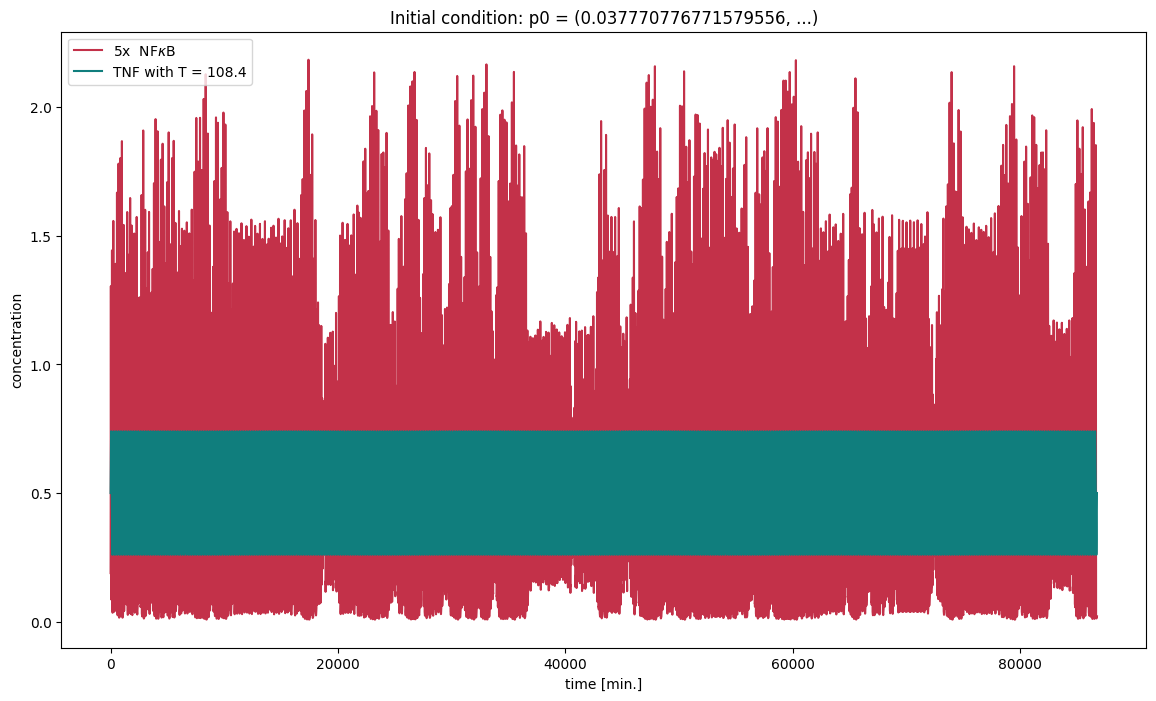

In [56]:
plt.figure(figsize=(14,8))
plt.plot(t0, x*N0, color=colors["nfkb"], alpha=1, label = f'{x}x  NF$\kappa$B')
plt.plot(t0, TNF0, alpha=1, color=colors["tnf"], label = f'TNF with T = {T_ext_0:.4}')
plt.title(rf'Initial condition: p0 = ({p0[0]}, ...)')
plt.xlabel('time [min.]')
plt.ylabel('concentration')
plt.legend()

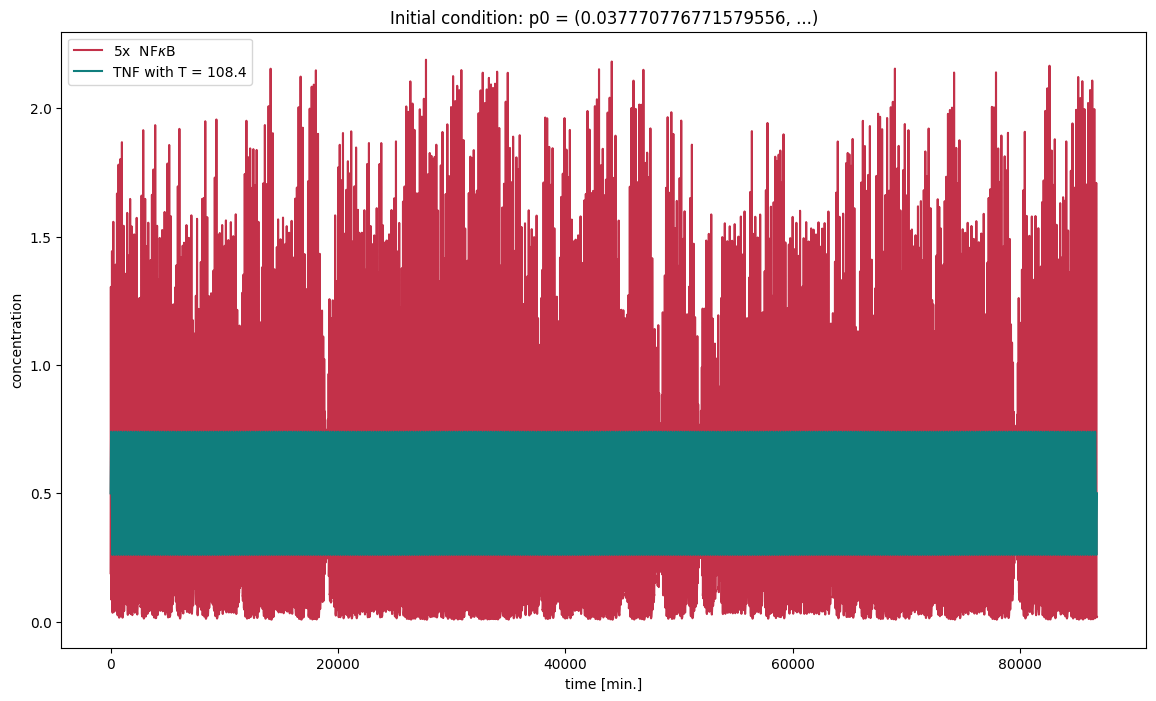

In [57]:
plt.figure(figsize=(14,8))
plt.plot(t1, x*N1, color=colors["nfkb"], alpha=1, label = f'{x}x  NF$\kappa$B')
plt.plot(t1, TNF1, alpha=1, color=colors["tnf"], label = f'TNF with T = {T_ext_0:.4}')
plt.title(rf'Initial condition: p0 = ({p0[0]}, ...)')
plt.xlabel('time [min.]')
plt.ylabel('concentration')
plt.legend()

# Divergens af trajectorier

Text(0.5, 0.92, 'Strange Attractor for NFkB')

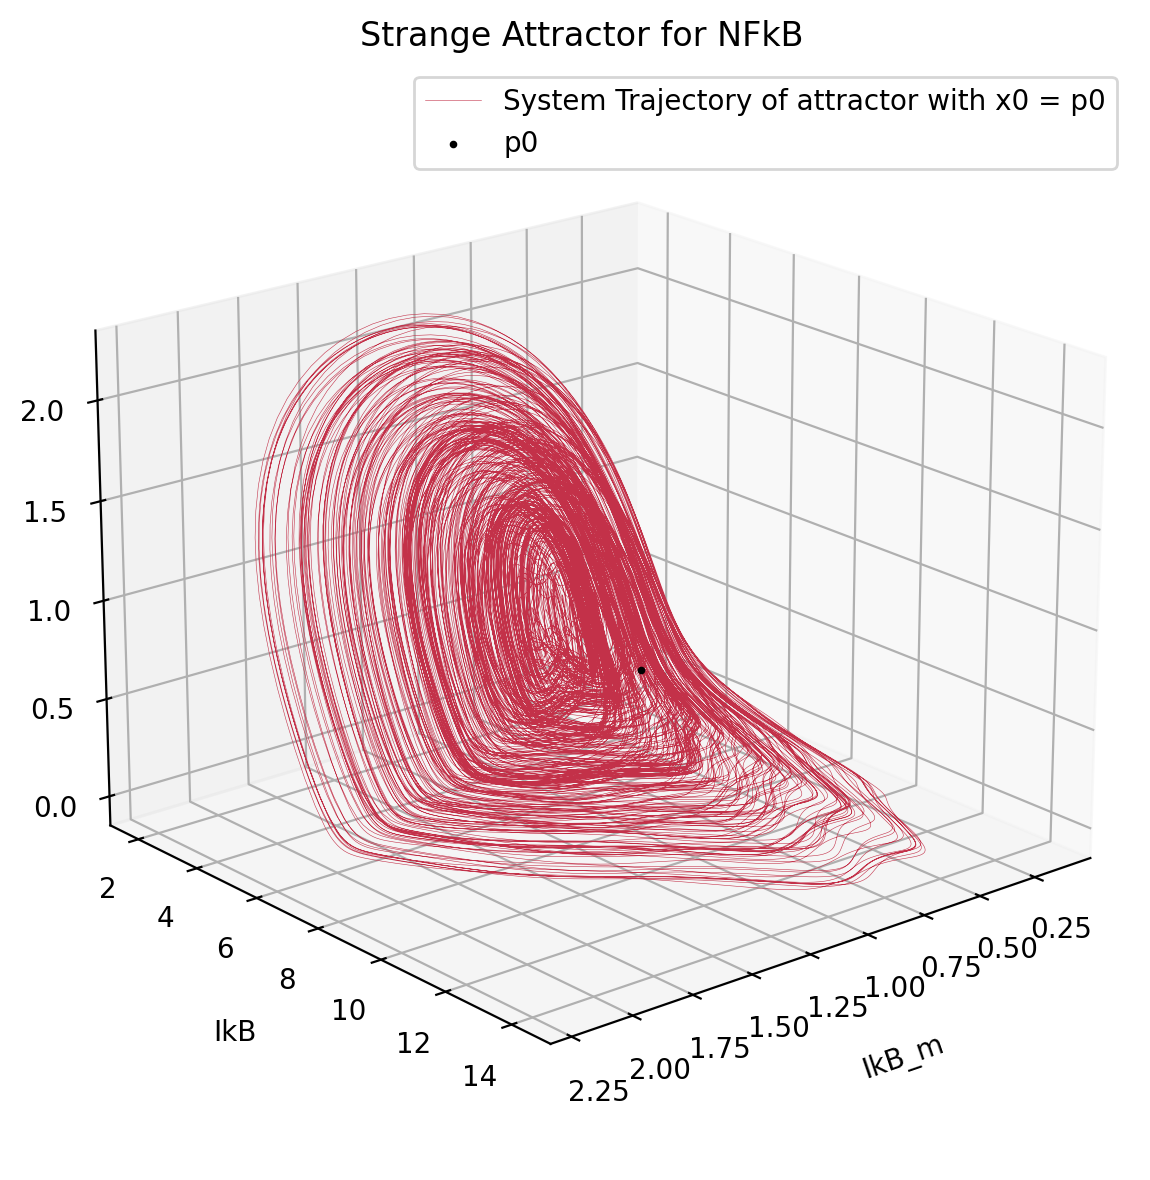

In [82]:
fig = plt.figure(figsize=(6, 6), dpi=200)
ax_3d = fig.add_subplot(111, projection='3d')  # Correct index for 3D plot
ax_3d.plot(Im0[transient_window:], I0[transient_window:], N0[transient_window:] * x, color=colors["nfkb"], lw=0.2, label=f'System Trajectory of attractor with x0 = p0')
ax_3d.scatter(Im0[0], I0[0], N0[0] * x, color="black", s=3, label=f'p0')
ax_3d.set_xlabel(r'IkB_m', labelpad=10)
ax_3d.set_ylabel('IkB', labelpad=10)
ax_3d.set_zlabel(f'{x}x NFkB', labelpad=10)
ax_3d.view_init(elev=20, azim=50) 

ax_3d.set_title(f'3D Phase Space')
ax_3d.legend()


plt.tight_layout()
plt.title("Strange Attractor for NFkB")

# Beregning af liapunov-eksponenten

In [1]:
trajectories = 4

In [124]:
all_final = []

for i in tqdm(range(trajectories)):
    index_to_vary = int(np.random.uniform(0, 3))
    delta = 1e-15 * np.random.uniform(1, 10)
    p0_d = p0.copy()
    p0_d[index_to_vary] = p0_d[index_to_vary] + delta
    sim_j, T_ext_j = TNF_sin_osc(no_osc, T_intt, Amp1, omega, *p0_d)
    tj, Nj, Imj, Ij, IKK_aj, IKK_ij, TNFj = np.array(sim_delta["t"]), np.array(sim_delta["N_n"]), np.array(sim_delta["I_m"]), np.array(sim_delta["I"]), np.array(sim_delta["IKK_a"]), np.array(sim_delta["IKK_i"]), np.array(sim_delta["TNF"])

    all_final.append([Imj[-1], Ij[-1], Nj[-1]])

 10%|█         | 1/10 [00:01<00:16,  1.86s/it]Traceback (most recent call last):
  File "/Users/erik/Documents/Studie/Projekt/python/p53/env/lib/python3.11/site-packages/scipy/integrate/_ivp/base.py", line 154, in fun
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
    return self.fun_single(t, y)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/erik/Documents/Studie/Projekt/python/p53/env/lib/python3.11/site-packages/scipy/integrate/_ivp/base.py", line 23, in fun_wrapped
    return np.asarray(fun(t, y), dtype=dtype)
                      ^^^^^^^^^
  File "/Users/erik/Documents/Studie/Projekt/python/p53/env/lib/python3.11/site-packages/scipy/integrate/_ivp/ivp.py", line 588, in fun
    return fun(t, x, *args)
           ^^^^^^^^^^^^^^^^
  File "/var/folders/k7/f1crpym10dq1jlwf0j2n3h080000gn/T/ipykernel_64977/4154720660.py", lin

: 

In [120]:
all_final = np.array(all_final)

Im_all = all_final[:, 0]
I_all = all_final[:, 1]
N_all = all_final[:, 2]

In [123]:
all_final

array([[4.51387043e-01, 8.59728890e+00, 4.71209569e-03],
       [4.51387043e-01, 8.59728890e+00, 4.71209569e-03],
       [4.51387043e-01, 8.59728890e+00, 4.71209569e-03],
       [4.51387043e-01, 8.59728890e+00, 4.71209569e-03],
       [4.51387043e-01, 8.59728890e+00, 4.71209569e-03],
       [4.51387043e-01, 8.59728890e+00, 4.71209569e-03],
       [4.51387043e-01, 8.59728890e+00, 4.71209569e-03],
       [4.51387043e-01, 8.59728890e+00, 4.71209569e-03],
       [4.51387043e-01, 8.59728890e+00, 4.71209569e-03],
       [4.51387043e-01, 8.59728890e+00, 4.71209569e-03]])

Text(0.5, 0.92, 'Strange Attractor for NFkB')

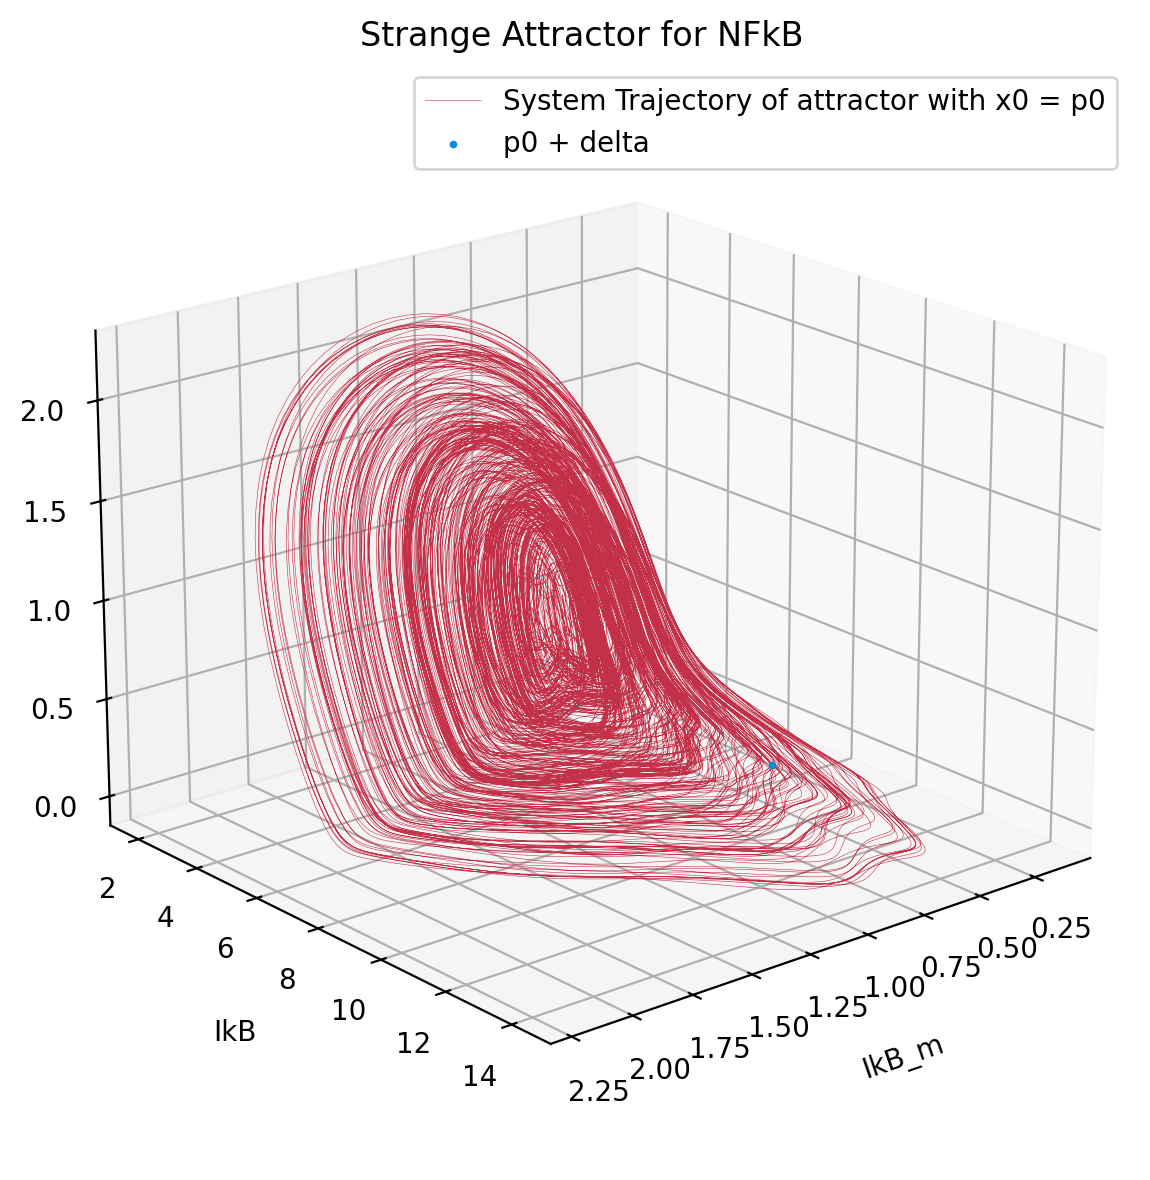

In [122]:
fig = plt.figure(figsize=(6, 6), dpi=200)
ax_3d = fig.add_subplot(111, projection='3d')  # Correct index for 3D plot
ax_3d.plot(Im0[transient_window:], I0[transient_window:], N0[transient_window:] * x, color=colors["nfkb"], lw=0.2, label=f'System Trajectory of attractor with x0 = p0')
ax_3d.scatter(Im_all[0], I_all[0], N_all[0] * x, color=colors["p53"], s=3, label=f'p0 + delta')
ax_3d.set_xlabel(r'IkB_m', labelpad=10)
ax_3d.set_ylabel('IkB', labelpad=10)
ax_3d.set_zlabel(f'{x}x NFkB', labelpad=10)
ax_3d.view_init(elev=20, azim=50) 

ax_3d.set_title(f'3D Phase Space')
ax_3d.legend()


plt.tight_layout()
plt.title("Strange Attractor for NFkB")